In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Log Anomaly Detection & Investigation with Text Embeddings + BigQuery Vector Search


<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fembeddings%2Fuse-cases%2Foutlier-detection%2Fbq-vector-search-outlier-detection-audit-logs.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/embeddings/use-cases/outlier-detection/bq-vector-search-outlier-detection-audit-logs.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/embeddings/use-cases/outlier-detection/bq-vector-search-outlier-detection-audit-logs.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/embeddings/use-cases/outlier-detection/bq-vector-search-outlier-detection-audit-logs.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|-|-|
| Author: | [Roy Arsan](https://github.com/rarsan) |

## Overview
Security and IT operations teams are tasked with analyzing an increasing amount of logs such as [Cloud Audit Logs](https://cloud.google.com/logging/docs/audit). At the same time, they are faced with a number of challenges, including shortage of talent, increased toil, and increased cyber threats. By leveraging AI for log analytics, cloud administrators, security analysts,  and threat hunters can keep up with these challenges:
- Proactively and intelligently identify cloud threats or misconfigurations
- Reduce the time and effort during a threat or incident investigation.

In this notebook, we will demonstrate **Generative AI-enabled outliers detection and incident investigation** using your Cloud Audit logs in your own project.


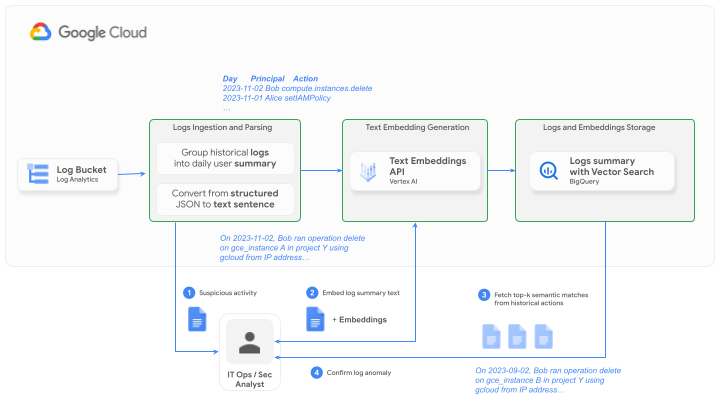

### Objective

Using [Vertex AI](https://cloud.google.com/vertex-ai/docs) and [BigQuery](https://cloud.google.com/bigquery/docs), you will:

*   Summarize and transform your logs from a verbose deeply nested complex structured payload into a natural language text summary.
*   Create embeddings for each textual log summary directly in BigQuery using [`textembedding-gecko` Generative AI model](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings) from Vertex AI.
*   Create a fully-managed BigQuery vector index to search all logs summaries without operational overhead.
*   Search directly in BigQuery to find any past actions that are semantically similar to suspected current actions.
*   Visualize findings in an interative table and timechart for rapid investigation & confirmation of such potential outliers.

## Getting Started

### Prerequisite
If you haven't already done so, the only requirement is to [upgrade your existing log bucket](https://cloud.google.com/logging/docs/buckets#upgrade-bucket) to use Log Analytics which provides you with a linked BigQuery dataset with your own queryable logs data. This is a **one-click step without incurring any additional costs**. By default, Cloud Audit Admin Activity logs are enabled, ingested and stored in every project's `_Required` bucket without any charges.

![one click prerequisite](https://services.google.com/fh/files/misc/upgrade_log_bucket.png)


### Install packages and SDKs

In [ ]:
# Install mpld3 package for interactive rendering of matplotlib
%pip install mpld3
# Install Vertex AI and BigQuery SDKs
%pip install google-cloud-aiplatform google-cloud-bigquery --upgrade --user

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment

Authenticating your notebook environment
- If you are using **Colab** to run this notebook, run the cell below and continue.
- If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
# For debug only
!gcloud config list --format 'value(core.account)'

### Import libraries

In [ ]:
from google.cloud import bigquery
import pandas as pd

In [ ]:
from google.colab import data_table

data_table.enable_dataframe_formatter()

### Set Google Cloud region and project ID

In [ ]:
PROJECT_ID = "[project-id]"  # @param {type:"string"}
LOCATION = "US"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

# Set the project id for gcloud CLI and BigQuery client libraries
!gcloud config set project {PROJECT_ID}
bq = bigquery.Client(project=PROJECT_ID)

## Prepare log data and convert to text

You'll preprocess the raw logs that reside in your BigQuery linked dataset (or `SOURCE_DATASET`) into a summary table in your new BigQuery dataset (`PROCESSED_DATASET`). This new dataset will contain the aggregated logs (daily user actions are coalesced) which will also be converted into a simple natural language text. It will also contain the text embeddings and vector index for semantic search.

Make sure you have **BigQuery Data Viewer** role over `SOURCE_DATASET` dataset

In [ ]:
SOURCE_DATASET = "[linked-dataset]"  # @param {type:"string"}
PROCESSED_DATASET = "[new-dataset]"  # @param {type:"string"}

TABLE_NAME = "nb_admin_actions_summary"  # @param {type:"string"}

### Create BigQuery dataset

In [ ]:
!bq --location={LOCATION} mk --dataset {PROJECT_ID}:{PROCESSED_DATASET}

### Define BigQuery User-Defined Functions (UDFs)

The following UDF helper function converts a structured log entry payload into a natural language text explaining the log entry activity of who did what, when, on which resource and from which ip and user agent. All of these dimensions are important facets to include in the text content and as a result, to consider in the embeddings vector space.

In [ ]:
# Produce user-friendly text content from an audit log entry's parameters
UDF_NAME = "stringifyAdminLogEntry"

sql = f"""
CREATE OR REPLACE FUNCTION `{PROJECT_ID}.{PROCESSED_DATASET}.{UDF_NAME}`(
  day DATE,
  principal_email STRING,
  action STRING,
  resource_type STRING,
  resource_id STRING,
  container_type STRING,
  container_id STRING,
  channel STRING,
  ip STRING,
  counter INT64
)
RETURNS STRING
AS (
  "On " || CAST(day AS STRING) || ", principal " || principal_email ||
  "  ran operation " || action || " over " || resource_type || " " ||
  resource_id || " in " || container_type || " " || container_id ||
  " using " || channel || " from ip " || ip || " " || counter || " time(s)"
);
"""

query_job = bq.query(sql)
print(query_job.result())  # Wait for the job to complete.
print(f"Created UDF {PROJECT_ID}.{PROCESSED_DATASET}.{UDF_NAME}")

The following UDF extracts the resource ID that was acted on per the audit log entry. In the audit log entry, The resource ID is specified in a different resource label field depending on the resource type. That's why this UDF is needed to normalize that resource ID field.

In [ ]:
# Deduce resource ID from a log entry resource field
UDF_NAME = "getResourceId"

sql = f"""
CREATE OR REPLACE FUNCTION `{PROJECT_ID}.{PROCESSED_DATASET}.{UDF_NAME}`(
  type STRING,
  labels JSON
)
RETURNS STRING
AS (
 COALESCE(
  JSON_VALUE(labels.email_id),     # service_account
  JSON_VALUE(labels.pod_id),       # container
  JSON_VALUE(labels.instance_id),  # gce_instance, spanner_instance, redis_instance, ...
  JSON_VALUE(labels.subnetwork_id),# gce_subnetwork,
  JSON_VALUE(labels.network_id),   # gce_network, gce_network_region, ...
  JSON_VALUE(labels.topic_id),     # pubsub_topic
  JSON_VALUE(labels.subscription_id), # pubsub_subscription
  JSON_VALUE(labels.endpoint_id),  # aiplatform.googleapis.com/Endpoint
  JSON_VALUE(labels.job_id),       # dataflow_step
  JSON_VALUE(labels.dataset_id),   # bigquery_dataset
  JSON_VALUE(labels.project_id),
  JSON_VALUE(labels.organization_id),
  JSON_VALUE(labels.id),
  "other")
);
"""

query_job = bq.query(sql)
print(query_job.result())  # Wait for the job to complete.
print(f"Created UDF {PROJECT_ID}.{PROCESSED_DATASET}.{UDF_NAME}")

The following UDF deduces where a user or system action occurred from per the audit log entry. For example, an action may have occurred through the Cloud Console, or using gcloud CLI, or via Terraform script or another unknown client or channel.

In [ ]:
# Deduce channel from a log entry request user agent
UDF_NAME = "getChannelType"

sql = f"""
CREATE OR REPLACE FUNCTION `{PROJECT_ID}.{PROCESSED_DATASET}.{UDF_NAME}`(
  caller_supplied_user_agent STRING
)
RETURNS STRING
AS (
  CASE
    WHEN caller_supplied_user_agent LIKE "Mozilla/%" THEN 'Cloud Console'
    WHEN caller_supplied_user_agent LIKE "google-cloud-sdk gcloud/%" THEN 'gcloud CLI'
    WHEN caller_supplied_user_agent LIKE "google-api-go-client/% Terraform/%" THEN 'Terraform'
    ELSE 'other'
  END
);
"""

query_job = bq.query(sql)
print(query_job.result())  # Wait for the job to complete.
print(f"Created UDF {PROJECT_ID}.{PROCESSED_DATASET}.{UDF_NAME}")

### Build summary table of admin actions

In [ ]:
LOOKBACK_WINDOW_DAYS = 360  # @param {type:"slider", min:30, max:1080, step:30}

In [ ]:
TABLE_ID = f"{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}"

job_config = bigquery.QueryJobConfig(
    destination=TABLE_ID, write_disposition="WRITE_TRUNCATE"
)

sql = f"""
SELECT
  {PROCESSED_DATASET}.stringifyAdminLogEntry(
    day, principal_email, action, resource_type, resource_id, container_type,
    container_id, channel, ip, counter) AS content,
  *
FROM (
  SELECT
    EXTRACT(DATE FROM timestamp) AS day,
    IFNULL(proto_payload.audit_log.authentication_info.principal_email, "unknown") as principal_email,
    IFNULL(proto_payload.audit_log.method_name, "unknown") as action,
    IFNULL(resource.type, "unknown") as resource_type,
    {PROCESSED_DATASET}.getResourceId(resource.type, resource.labels) AS resource_id,
    -- proto_payload.audit_log.resource_name as resource_name,
    SPLIT(log_name, '/')[SAFE_OFFSET(0)] as container_type,
    SPLIT(log_name, '/')[SAFE_OFFSET(1)] as container_id,
    {PROCESSED_DATASET}.getChannelType(proto_payload.audit_log.request_metadata.caller_supplied_user_agent) AS channel,
    IFNULL(proto_payload.audit_log.request_metadata.caller_ip, "unknown") as ip,
    COUNT(*) counter,
    -- ANY_VALUE(resource) as resource,           -- for debugging
    -- ANY_VALUE(proto_payload) as proto_payload  -- for debugging
  FROM  `{PROJECT_ID}.{SOURCE_DATASET}._AllLogs`
  WHERE
    -- log_id = "cloudaudit.googleapis.com/activity" AND
    timestamp > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL {LOOKBACK_WINDOW_DAYS} DAY)
  GROUP BY
    day, principal_email, action, resource_type, resource_id, container_type, container_id, channel, ip, log_name
  ORDER BY
    day DESC, principal_email, action
)
"""

# Start the query and save results in new table
query_job = bq.query(sql, job_config=job_config)
result = query_job.result()  # Wait for the job to complete.

print(f"{result.total_rows} admin action records loaded to table {TABLE_ID}")

Let's peak into some of these summarized daily user actions:

In [ ]:
result.to_dataframe().head(10)

Below are example daily user actions summarizing what action was taken by whom, on what resource, and from where:

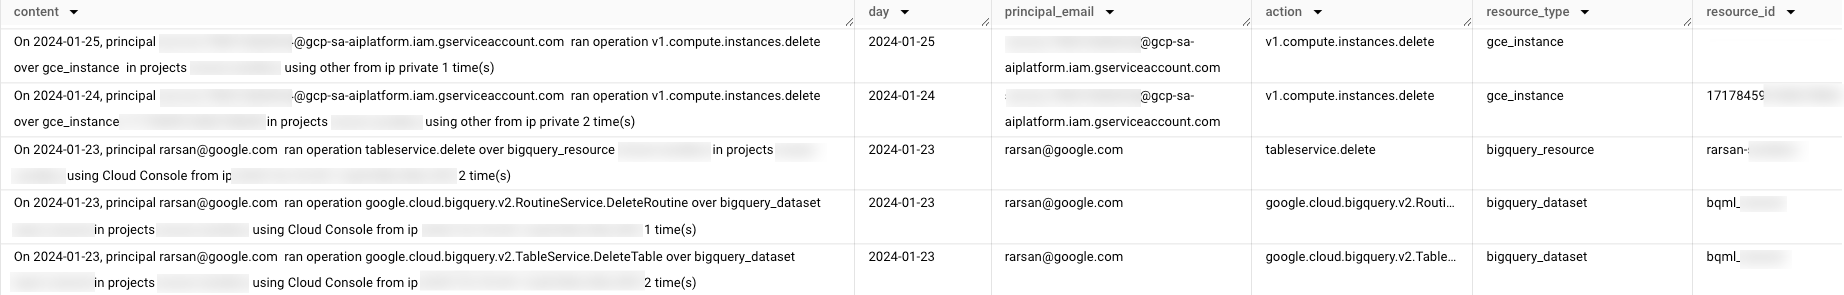

## Generate text embeddings for logs

### Create BigQuery Cloud resource connection

You need to create a Cloud resource connection to enable BigQuery Dataframes to interact with Vertex AI services

In [ ]:
CONN_NAME = "bqdf-llm-embeddings"

In [ ]:
!bq mk --connection --location={LOCATION} --project_id={PROJECT_ID} \
    --connection_type=CLOUD_RESOURCE {CONN_NAME}

Retrieve the connection service account ID

In [ ]:
!bq show --connection {PROJECT_ID}.{LOCATION}.{CONN_NAME}

Copy the service account ID in the following parameter:

In [ ]:
# Copy the value of `serviceAccountId` field in last cell's output
CONN_SA_ID = "[bq-connection-service-account]"  # @param {type:"string"}

Give that service account access to Vertex AI

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --member='serviceAccount:{CONN_SA_ID}' --role='roles/aiplatform.user' --condition=None --no-user-output-enabled

### Define the LLM model

Let's create a remote model in BigQuery using the above BigQuery connection. The remote endpoint is set as `textembeddings-gecko` LLM model in Vertex AI.

In [ ]:
LLM_ENDPOINT = "textembedding-gecko"
MODEL_NAME = "embedding_model"

sql = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{PROCESSED_DATASET}.{MODEL_NAME}`
REMOTE WITH CONNECTION `{PROJECT_ID}.{LOCATION}.{CONN_NAME}`
OPTIONS (ENDPOINT = '{LLM_ENDPOINT}');
"""

# Start the query
query_job = bq.query(sql)
print(query_job.result())  # Wait for the job to complete.
print(f"Created remote model {PROJECT_ID}.{PROCESSED_DATASET}.{MODEL_NAME}")

### Generate embedding for each log summary

The following code generates text embedding for each past action in your admin actions summary table. All records including their embeddings are saved into a new table with suffix `_embeddings`.

  CAUTION: This may take several minutes and incur Vertex AI costs depending on how many rows in your table.

In [ ]:
TABLE_ID = f"{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_embeddings"

job_config = bigquery.QueryJobConfig(
    destination=TABLE_ID, write_disposition="WRITE_TRUNCATE"
)

sql = f"""
SELECT
  * EXCEPT (ml_embed_text_status, statistics),
FROM ML.GENERATE_TEXT_EMBEDDING(
  MODEL `{PROJECT_ID}.{PROCESSED_DATASET}.{MODEL_NAME}`,
  TABLE `{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}`,
  STRUCT(TRUE AS flatten_json_output)
)
"""

# Start the query and save results in new table
query_job = bq.query(sql, job_config=job_config)
results = query_job.result()  # Wait for the job to complete.

print(f"{results.total_rows} embedded admin actions loaded to table {TABLE_ID}")

Let's peak into some of the embedded admin actions:

In [ ]:
results.to_dataframe().head(2)

## Search logs with BigQuery Vector Search

### Create a vector index

In [ ]:
sql = f"""
CREATE OR REPLACE VECTOR INDEX `my_vector_index`
ON `{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_embeddings`(text_embedding)
OPTIONS(distance_type='COSINE', index_type='IVF');
"""

query_job = bq.query(sql)
print(query_job.result())  # Wait for the job to complete.
print(
    f"Created Vector index for {PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_embeddings"
)

Inspect vector index progress, and total storage (chargeable) from `INFORMATION_SCHEMA.VECTOR_INDEXES` view:

In [ ]:
sql = f"""
SELECT
  table_name,
  index_name,
  coverage_percentage,
  unindexed_row_count,
  total_logical_bytes,
  total_storage_bytes
FROM `{PROJECT_ID}.{PROCESSED_DATASET}.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE';
"""
query_job = bq.query(sql)
results = query_job.result()  # Wait for the job to complete
results.to_dataframe()

### Vector search across existing embeddings

Pick a couple of recent suspicious actions from the summary table with embeddings, and save into a new table of actions to investigate:

In [ ]:
TABLE_ID = f"{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_test_actions"

job_config = bigquery.QueryJobConfig(
    destination=TABLE_ID, write_disposition="WRITE_TRUNCATE"
)

# Search for any N destructive actions (containing 'delete') over the last week
sql = f"""
SELECT
  *
FROM  `{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_embeddings`
WHERE
  day > DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY) AND
  lower(action) LIKE "%delete%"
LIMIT 2
"""

# Start the query and save results in new table
query_job = bq.query(sql, job_config=job_config)
results = query_job.result()  # Wait for the job to complete.

print(
    f"{results.total_rows} suspicious admin action records loaded to table {TABLE_ID}"
)

As part of your investigation, let's confirm whether each of these actions is an anomaly or not. We can do so using a semantic search across all past actions to find out if a similar activity has occurred in the past.

In [ ]:
sql = f"""
SELECT
  query.content as suspicious_action,
  base.content as past_similar_action,
  distance,
  base.day as day,
  base.counter as counter,
FROM VECTOR_SEARCH(
  TABLE `{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_embeddings`, 'text_embedding',
  TABLE `{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_test_actions`,
  top_k => 5
)
WHERE query.content != base.content -- remove exact dups
"""

# Start the query and save results in an in-memory dataframe
query_job = bq.query(sql)
results = query_job.result()  # Wait for the job to complete
df = results.to_dataframe()
df

#### Visualize results

<ins>In a table</ins>:

First, create helper functions to:
- Reshape the dataframe to group by suspicious action and list associated similar actions,
- Infer likelihood of equivalency (`likelihood`) for each pair given nearest neighbor distance (`distance`),
- Apply custom table styling to highlight "very similar" actions (d < 0.01) that are deemed equivalent

In [ ]:
def similarity(d):
    if d < 0.01:
        return "Very similar"
    elif d < 0.04:
        return "Similar"
    return "Somewhat similar"


def reshape(df):
    df2 = df.copy().query("distance > 0.000000000001")
    df2["suspected"] = True
    df2["likelihood"] = df2["distance"].apply(similarity)
    df2.sort_values(by="day", inplace=True)

    pivoted = df2.pivot(
        index=["suspicious_action", "past_similar_action"],
        columns="suspected",
        values=["day", "distance", "likelihood"],
    )
    return pivoted


def highlight_similar_actions(styler):
    styler.highlight_between(
        left=0,
        right=0.01,
        axis=1,
        subset=["distance"],
        props="color:white; font-weight:bold; background-color:darkblue;",
    )
    return styler

In [ ]:
reshape(df).style.pipe(highlight_similar_actions)

The results will be rendered in a table as follows:

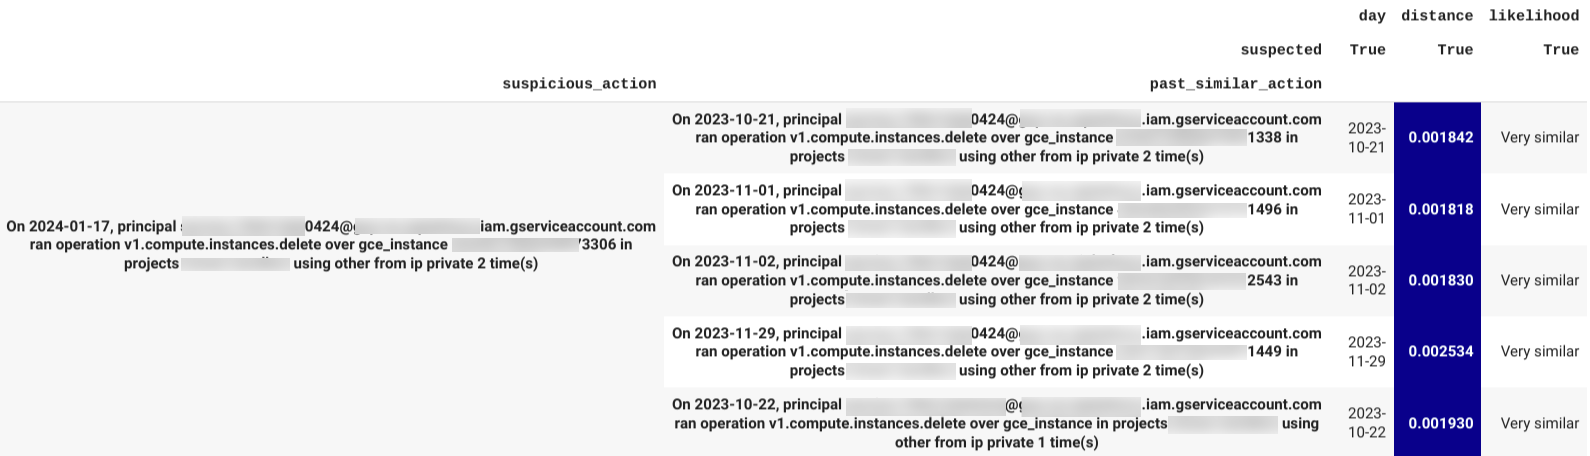

In this example, the search returned similar past action by the same service account on several occasions in the past, so the suspected action is deemed **not an anomaly**

<ins>In a timechart</ins>:

First, create helper function to plot the dataframe of past actions grouped by a given suspicious action:

In [ ]:
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins


def plot_actions_over_time(df):
    mpld3.enable_notebook()

    # Set CSS to style our custom labels
    css = """
  p {
    font-size: 14px;
    color: blue;
    background-color: white;
  }
  """

    fig, ax = plt.subplots(figsize=(12, 8))

    df["day"] = pd.to_datetime(df["day"])
    for i, ts in df.groupby("suspicious_action"):
        points = ax.plot(
            ts.day, ts.distance, "o", label=str(i), mec="k", ms=15, mew=1, alpha=0.6
        )
        labels = list(ts.past_similar_action.apply(lambda x: f"<p>{x}</p>"))
        tooltip = plugins.PointHTMLTooltip(
            points[0], labels, voffset=10, hoffset=10, css=css
        )
        plugins.connect(fig, tooltip)

    ax.legend(loc="upper left", bbox_to_anchor=(-0.1, 1.1))
    ax.set_xlabel("time")
    ax.set_ylabel("distance")
    plt.show()

    mpld3.disable_notebook()

In [ ]:
plot_actions_over_time(df)

The results will be rendered in a timechart as follows, where past closest matches of each suspected action are displayed in a separate line chart. The y-axis represents the distance of these nearest neighbors to the suspected action, where 0 is exact match.

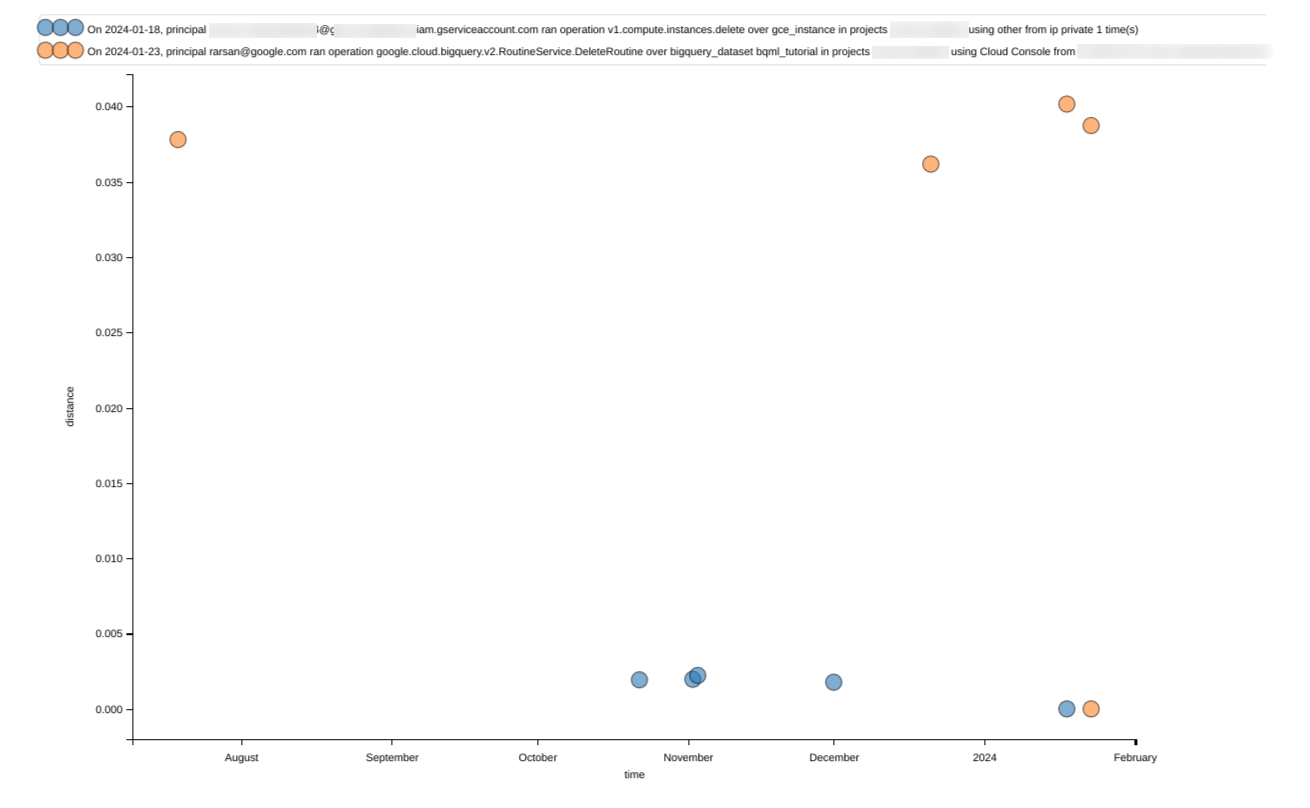

In this example, the 'orange' dots are not close enough matches and therefore the suspected action of 'DeleteRoutine' is likely an anomaly that needs to be further investigated.

### Vector search of a new log entry

Let's pick a seemingly suspicious destructive action from your recent admin activity log stream

In [ ]:
inner_sql = f"""
SELECT
  EXTRACT(DATE FROM timestamp) AS day,
  IFNULL(proto_payload.audit_log.authentication_info.principal_email, "unknown") as principal_email,
  IFNULL(proto_payload.audit_log.method_name, "unknown") as action,
  IFNULL(resource.type, "unknown") as resource_type,
  {PROCESSED_DATASET}.getResourceId(resource.type, resource.labels) AS resource_id,
  -- proto_payload.audit_log.resource_name as resource_name,
  SPLIT(log_name, '/')[SAFE_OFFSET(0)] as container_type,
  SPLIT(log_name, '/')[SAFE_OFFSET(1)] as container_id,
  {PROCESSED_DATASET}.getChannelType(proto_payload.audit_log.request_metadata.caller_supplied_user_agent) AS channel,
  IFNULL(proto_payload.audit_log.request_metadata.caller_ip, "unknown") as ip,
  COUNT(*) counter,
FROM  `{PROJECT_ID}.{SOURCE_DATASET}._AllLogs`
WHERE
  log_id = "cloudaudit.googleapis.com/activity" AND
  timestamp > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 1 DAY) AND
  lower(proto_payload.audit_log.method_name) LIKE "%delete%"
GROUP BY
  day, principal_email, action, resource_type, resource_id, container_type, container_id, channel, ip, log_name
ORDER BY
  day DESC,
  counter DESC
LIMIT 2
"""

# Start the query and save results in an in-memory dataframe
query_job = bq.query(inner_sql)
results = query_job.result()  # Wait for the job to complete
results.to_dataframe()

In the following singular SQL command, 1) convert the suspected log into a text string summary, 2) generate the text embeddings 2) and do vector search across all past actions to find out similar activity (if any) has occurred in the past:

In [ ]:
sql = f"""
SELECT
  query.content as suspicious_action,
  base.content as past_similar_action,
  distance,
  base.day as day,
  base.counter as counter
FROM VECTOR_SEARCH(
  TABLE `{PROJECT_ID}.{PROCESSED_DATASET}.{TABLE_NAME}_embeddings`,
  'text_embedding',
  (SELECT
    text_embedding, content
    FROM ML.GENERATE_TEXT_EMBEDDING(
      MODEL `{PROJECT_ID}.{PROCESSED_DATASET}.embedding_model`,
      (SELECT
        {PROCESSED_DATASET}.stringifyAdminLogEntry(
          day, principal_email, action, resource_type, resource_id, container_type,
          container_id, channel, ip, counter) AS content
        FROM ({inner_sql})),
      STRUCT(TRUE AS flatten_json_output)
  )),
  top_k => 5
)
WHERE query.content != base.content -- remove potential dups
"""

# Start the query and save results in an in-memory dataframe
query_job = bq.query(sql)
results = query_job.result()  # Wait for the job to complete
df = results.to_dataframe()

#### Visualize results

<ins>In a table<ins>:

In [ ]:
reshape(df).style.pipe(highlight_similar_actions)

<ins>In a timechart</ins>:

In [ ]:
plot_actions_over_time(df)

## Summary

In this notebook, you were able to:
- Process your Google Cloud audit logs into a summary table for easier, faster and cost-effective log analysis
- Convert logs from semi-structured deeply nested JSON payload into a concise textual log summary 
- Generate embeddings for each log summary using Vertex AI, and store them in a BigQuery table alongside the log content
- Create a vector index in BigQuery to semantically search all historical log summaries using embeddings column
- Search logs using BigQuery `VECTOR_SEARCH` SQL command to detect & investigate suspicious or anomalous activity
- Visualize findings in a table and a timechart to highlight past similar or equivalent actions, if any

## Cleanup

To clean up all Google Cloud resources used in this notebook, you can delete the Google Cloud project you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial, namely the BigQuery dataset `PROCESSED_DATASET` with the processed data:

In [ ]:
# Delete the created BigQuery dataset
!bq rm -r -f {PROJECT_ID}:{PROCESSED_DATASET}